In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from scipy import stats
import itertools
from statsmodels.tsa.stattools import coint


# 1. Load data
start_df = pd.read_csv('Data.csv')
start_df['Dates'] = pd.to_datetime(start_df['Dates'])
start_df = start_df.sort_values('Dates').set_index('Dates')

# 2. Clean the dataset and reject the negative price. It's the pragmatic thing to do at this stage.
start_df = start_df[start_df > 0]

# 3. I do not know how to handle things I cannot convert into USD. So I drop them.
start_df = start_df.drop(['Brazil_Equity', 'Australia_Equity', 'UK_10y','CADBRL','GBPMXN','SGDBRL','CHFJPY'], axis=1)

# Definizione delle valute per ciascun asset (in base all'immagine)
asset_currency = {
    'Germany_Equity': 'EUR',
    'Spain_Equity': 'EUR',
    'Germany_2y': 'EUR',
    'Germany_10y': 'EUR',
    'Japan_Equity': 'JPY',
    'Japan_10y': 'JPY',
    'Nasdaq': 'USD',
    'US_2y': 'USD',
    'US_10y': 'USD',
    'Gold': 'USD',
    'Oil': 'USD',
    'Wheat': 'USD',
    'Corn': 'USD',
    'Rice': 'USD',
    'Copper': 'USD'
}

# Prepariamo un nuovo DataFrame con i prezzi convertiti in USD
df_usd = pd.DataFrame(index=start_df.index)

for col in start_df.columns:
    if col in ['EURUSD', 'USDJPY']:  # saltiamo i tassi di cambio
        continue
    currency = asset_currency[col]
    if currency == 'USD':
        df_usd[col] = start_df[col]  # già in USD
    elif currency == 'EUR':
        df_usd[col] = start_df[col] * start_df['EURUSD']
    elif currency == 'JPY':
        df_usd[col] = start_df[col] / start_df['USDJPY']  # conversione JPY → USD
    else:
        pass  # ignora colonne senza valuta definita


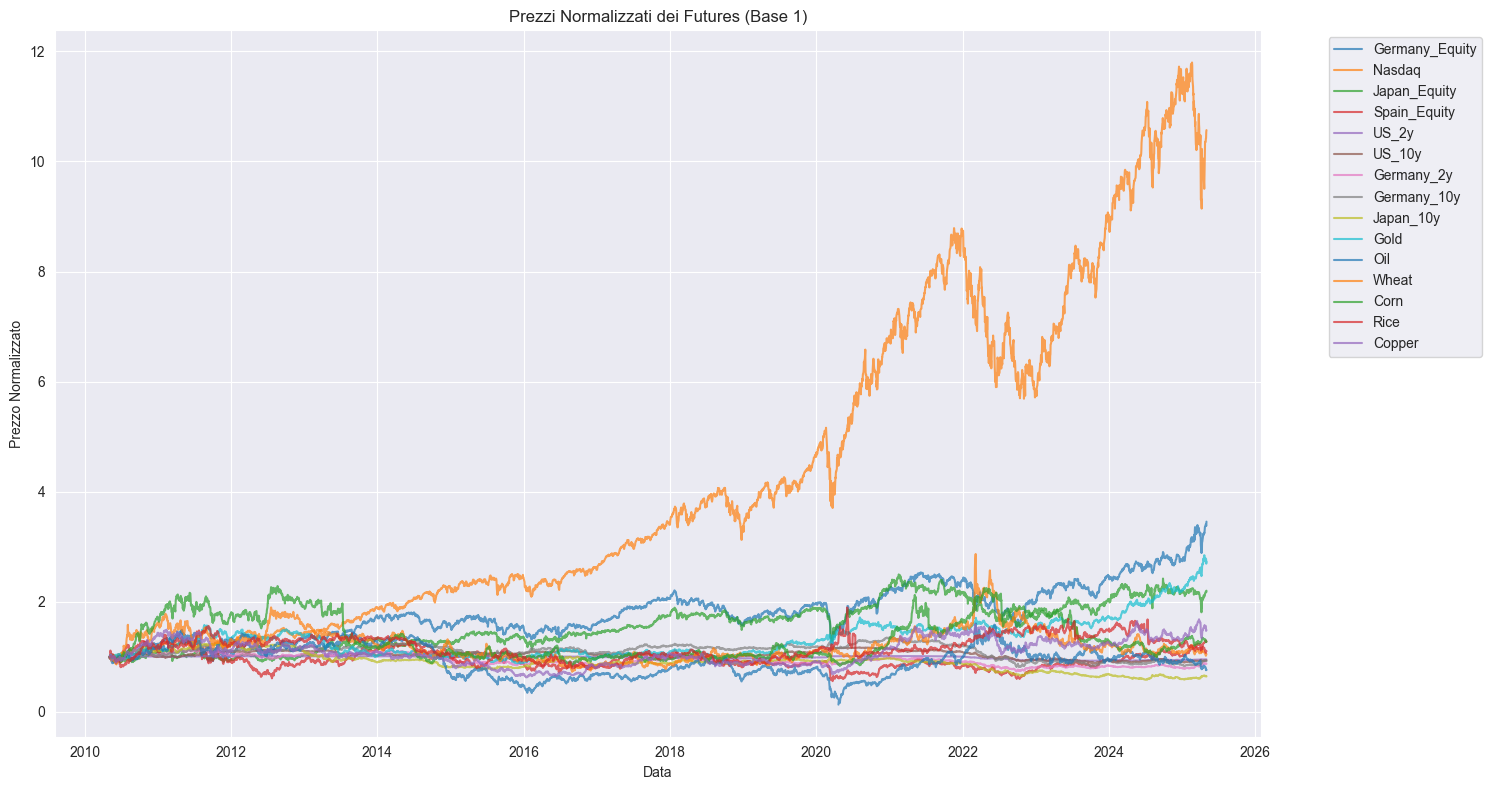

In [2]:
# Plot: andamento dei prezzi normalizzati
normalized_prices = df_usd / df_usd.iloc[0]

plt.figure(figsize=(15, 8))
for col in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[col], label=col, alpha=0.7)
plt.title("Prezzi Normalizzati dei Futures (Base 1)")
plt.xlabel("Data")
plt.ylabel("Prezzo Normalizzato")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


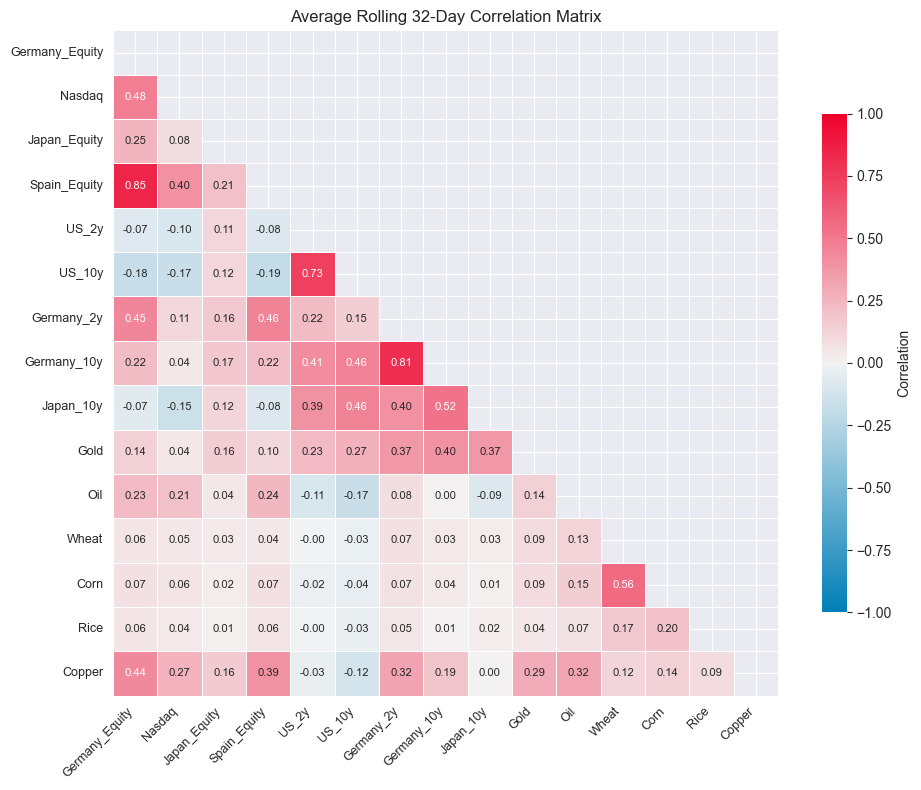

In [3]:
# Calcolo dei log returns
log_returns = np.log(df_usd / df_usd.shift(1)).dropna()

# Heatmap delle correlazioni tra log returns
corr_log_returns = log_returns.corr()
assets = log_returns.columns
mask = np.triu(np.ones_like(corr_log_returns, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9, s=100, l=50, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_log_returns,
    mask=mask,
    cmap=palette,        # diverging palette
    vmin=-1, vmax=1,        # ensure full correlation range
    center=0,
    annot=True,             # show numbers
    fmt=".2f",              # 2 decimal places
    annot_kws={"size": 8},  # control number size
    square=True,            # make cells square
    linewidths=0.5,         # white lines between cells
    xticklabels=assets,     # <— here
    yticklabels=assets,
    cbar_kws={"shrink": 0.75, "label": "Correlation"})
plt.title("Average Rolling 32-Day Correlation Matrix")
# Tweak the tick labels
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()
plt.close()

In [11]:
# Calcolo dei log-prezzi di tutti gli asset
log_prices_all = np.log(df_usd).dropna()

# Lista delle possibili coppie (combinazioni di 2 asset)
asset_pairs = list(combinations(log_prices_all.columns, 2))

# Risultati ADF test
adf_results = []

for asset1, asset2 in asset_pairs:
    spread = log_prices_all[asset1] - log_prices_all[asset2]
    adf_stat, p_value, _, _, _, _ = adfuller(spread)
    adf_results.append({
        "Asset 1": asset1,
        "Asset 2": asset2,
        "ADF Statistic": adf_stat,
        "p-value": p_value
    })

# DataFrame dei risultati ordinato per p-value crescente
adf_df = pd.DataFrame(adf_results).sort_values("p-value")

In [5]:
adf_df[adf_df["p-value"] < 0.05]

,Asset 1,Asset 2,ADF Statistic,p-value
95,Oil,Wheat,-4.469210,0.000223
97,Oil,Rice,-4.354948,0.000356
99,Wheat,Corn,-4.340674,0.000377
96,Oil,Corn,-4.101073,0.000965
100,Wheat,Rice,-3.831137,0.002604
104,Rice,Copper,-3.673134,0.004507
101,Wheat,Copper,-3.635581,0.005116
103,Corn,Copper,-3.055007,0.030067
98,Oil,Copper,-2.966170,0.038177
56,US_2y,Wheat,-2.869386,0.049026


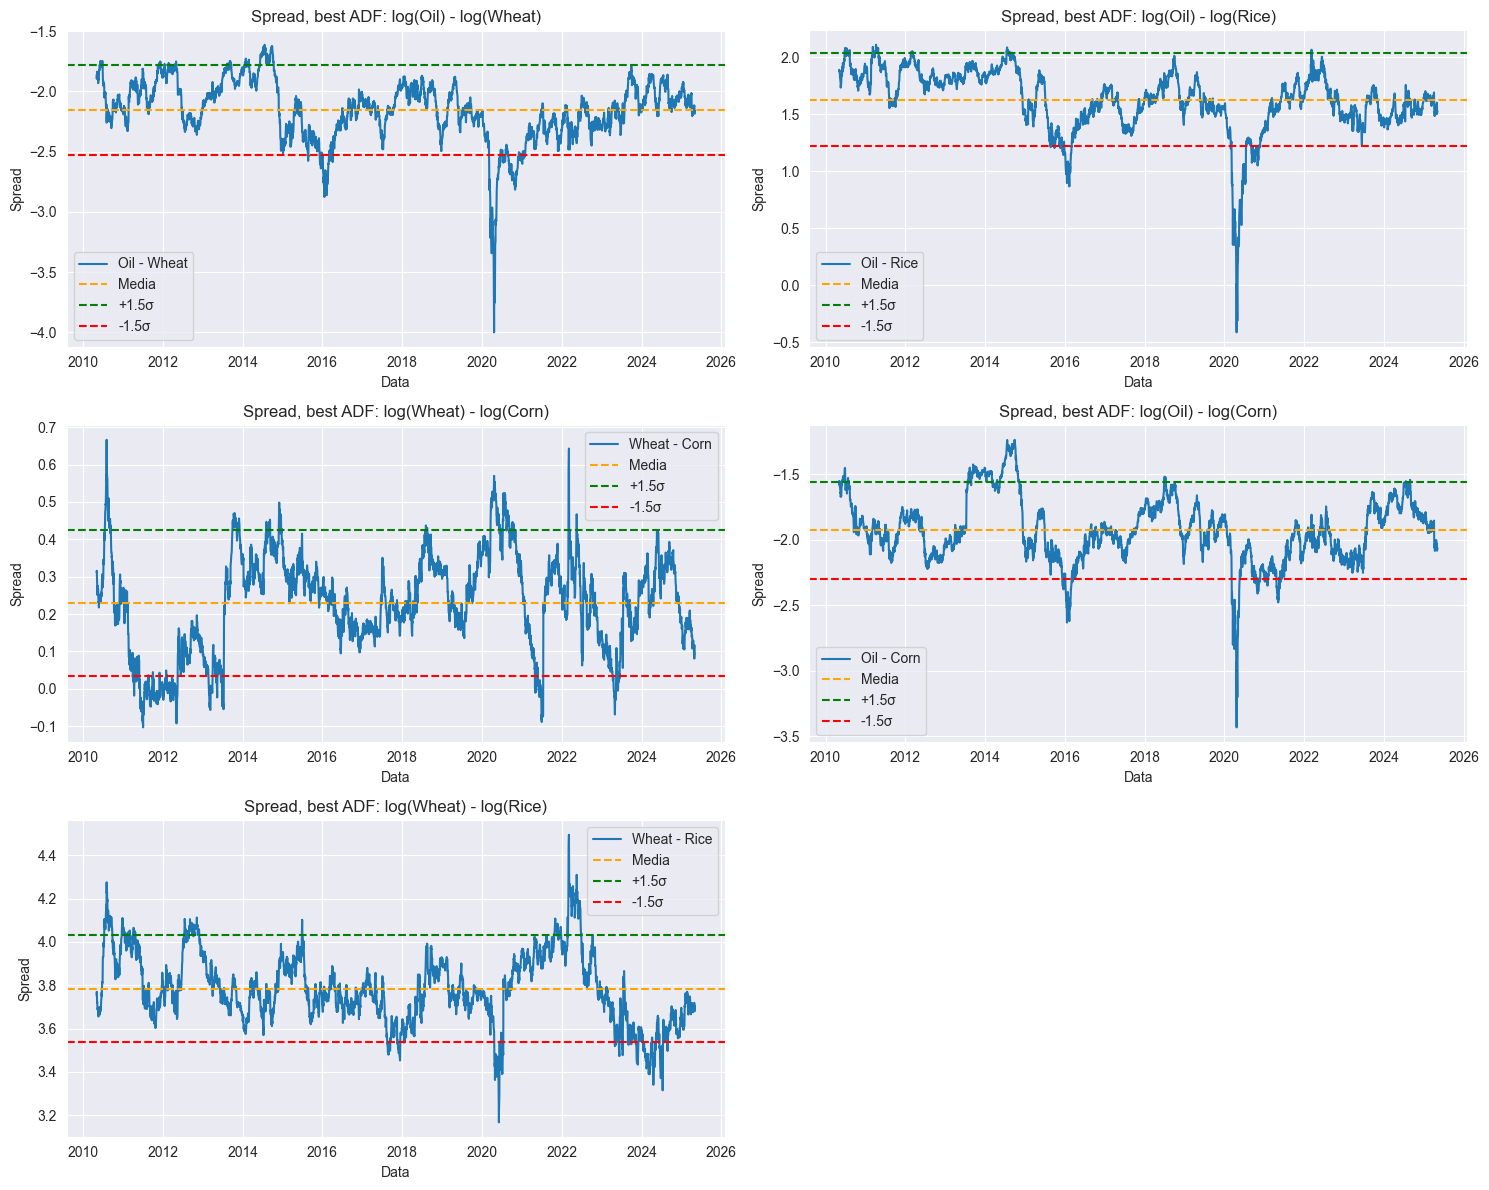

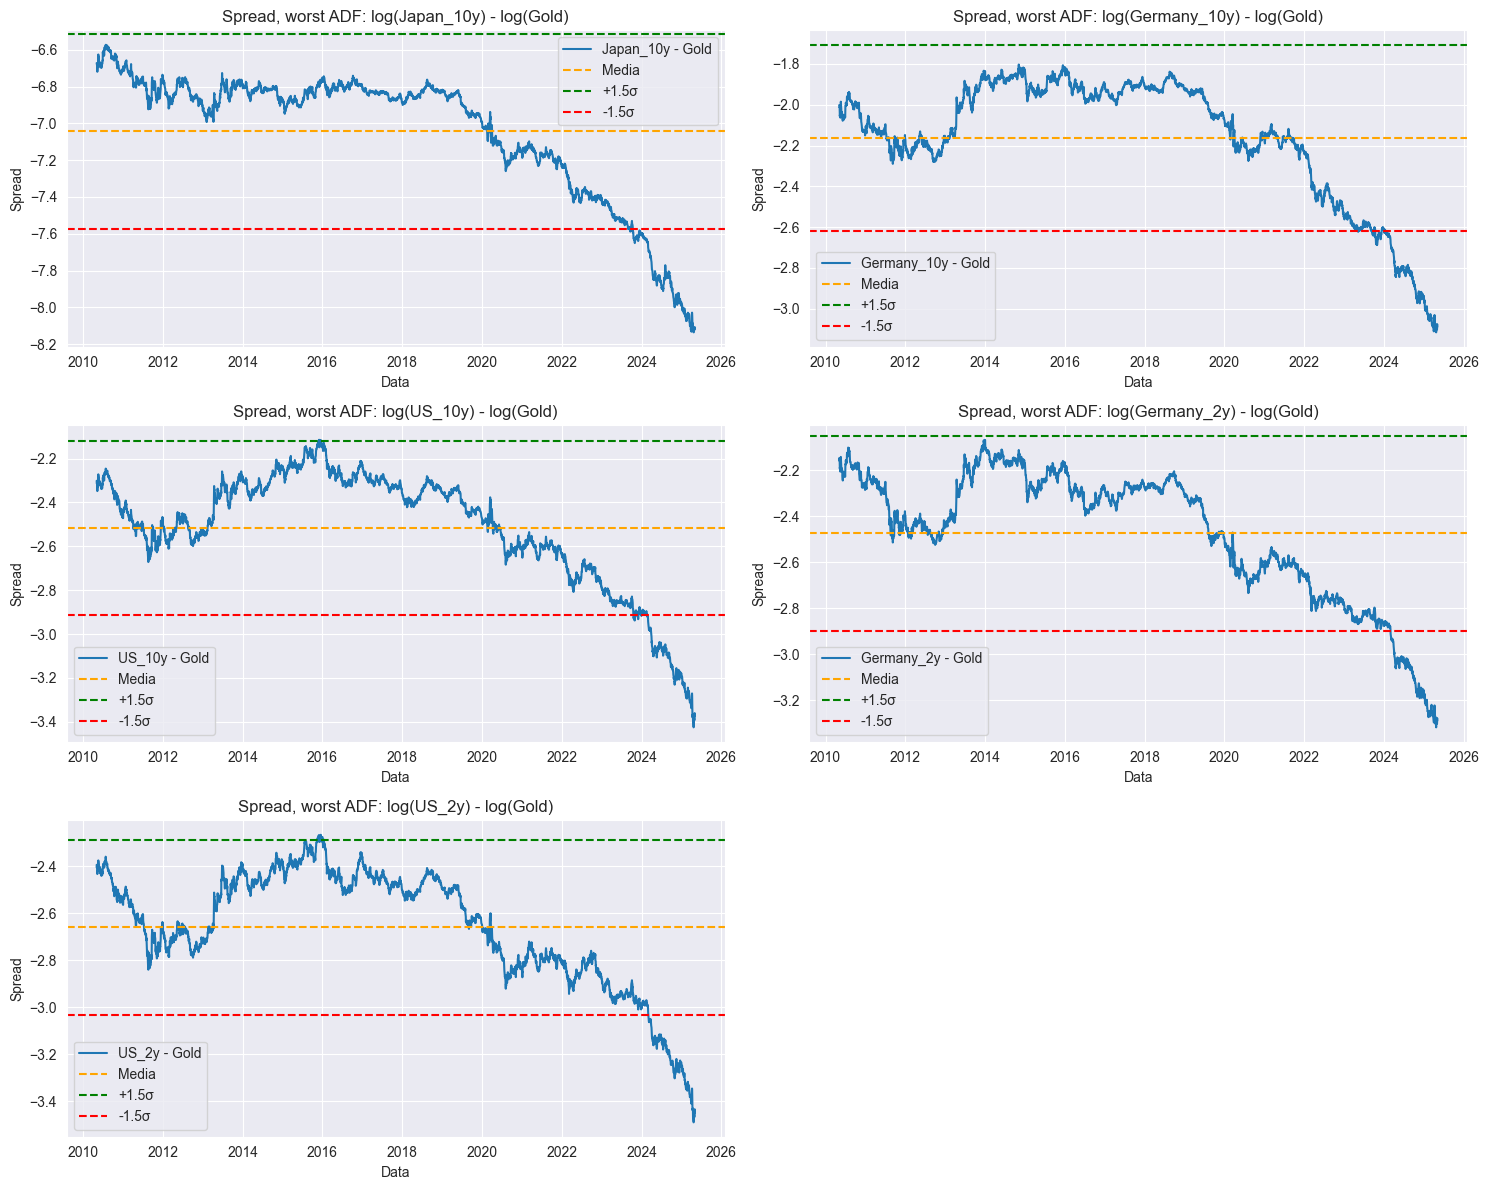

In [6]:
top_5_pairs = adf_df.nsmallest(5, "p-value")[["Asset 1", "Asset 2"]].values
bottom_5_pairs = adf_df.nlargest(5, "p-value")[["Asset 1", "Asset 2"]].values
# Calcolo e plottaggio degli spread log-price per ciascuna delle top 5 coppie
plt.figure(figsize=(15, 12))
for i, (asset1, asset2) in enumerate(top_5_pairs, 1):
    spread = log_prices_all[asset1] - log_prices_all[asset2]
    mean = spread.mean()
    std = spread.std()
    upper = mean + 1.5 * std
    lower = mean - 1.5 * std
    plt.subplot(3, 2, i)
    plt.plot(spread.index, spread, label=f"{asset1} - {asset2}")
    plt.axhline(spread.mean(), color='orange', linestyle='--', label="Media")
    plt.axhline(upper, color='green', linestyle='--', label="+1.5σ")
    plt.axhline(lower, color='red', linestyle='--', label="-1.5σ")
    plt.title(f"Spread, best ADF: log({asset1}) - log({asset2})")
    plt.xlabel("Data")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(15, 12))
for i, (asset1, asset2) in enumerate(bottom_5_pairs, 1):
    spread = log_prices_all[asset1] - log_prices_all[asset2]
    mean = spread.mean()
    std = spread.std()
    upper = mean + 1.5 * std
    lower = mean - 1.5 * std
    plt.subplot(3, 2, i)
    plt.plot(spread.index, spread, label=f"{asset1} - {asset2}")
    plt.axhline(spread.mean(), color='orange', linestyle='--', label="Media")
    plt.axhline(upper, color='green', linestyle='--', label="+1.5σ")
    plt.axhline(lower, color='red', linestyle='--', label="-1.5σ")
    plt.title(f"Spread, worst ADF: log({asset1}) - log({asset2})")
    plt.xlabel("Data")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

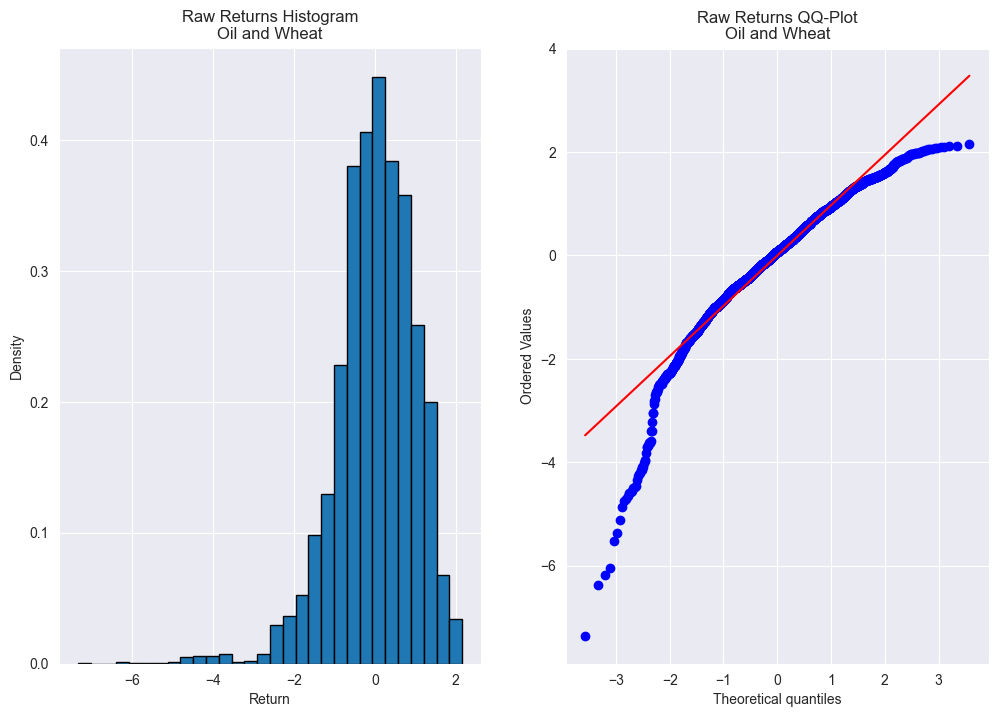

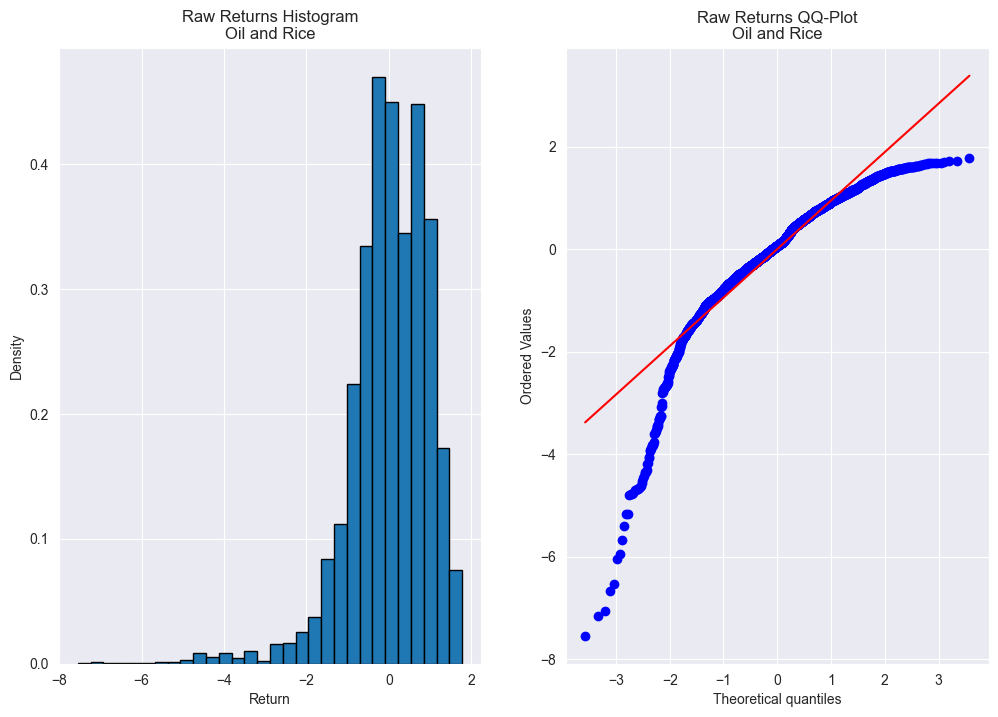

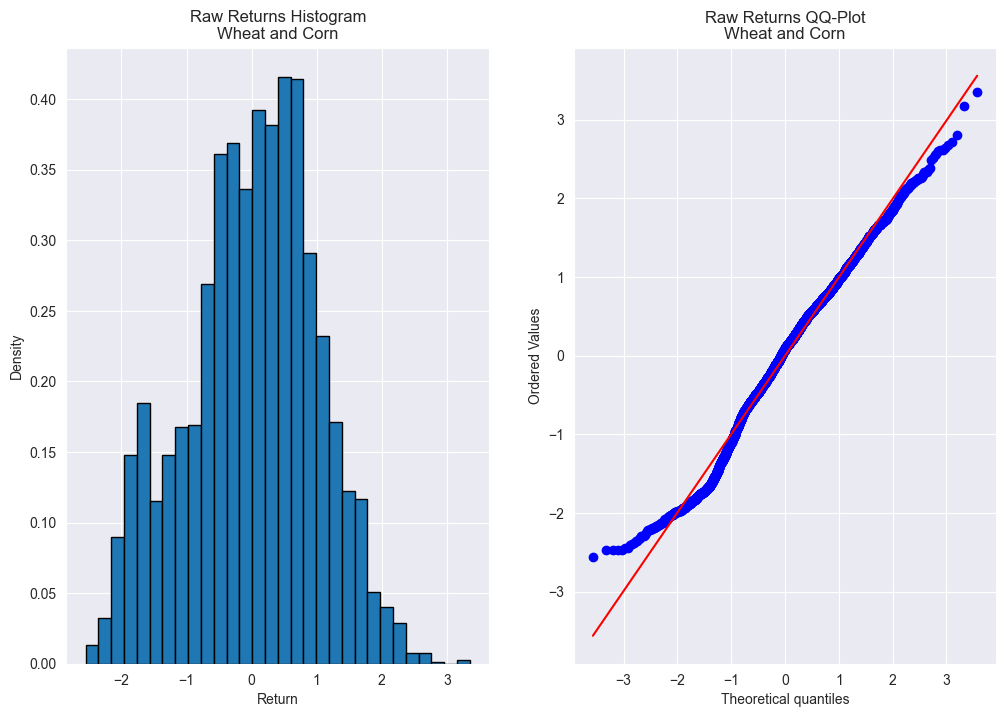

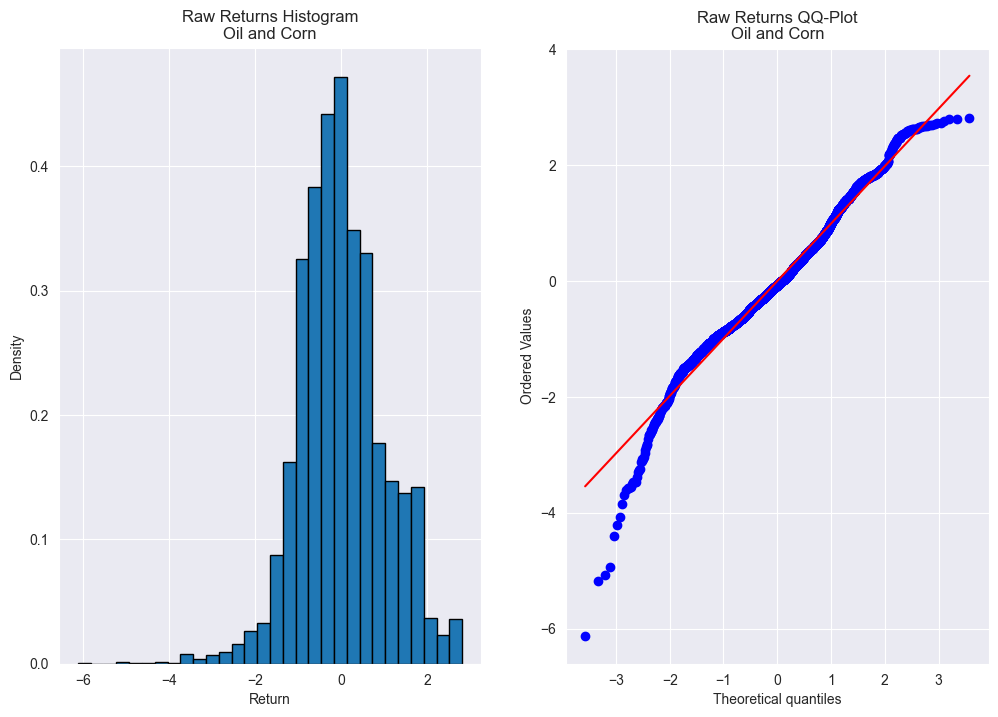

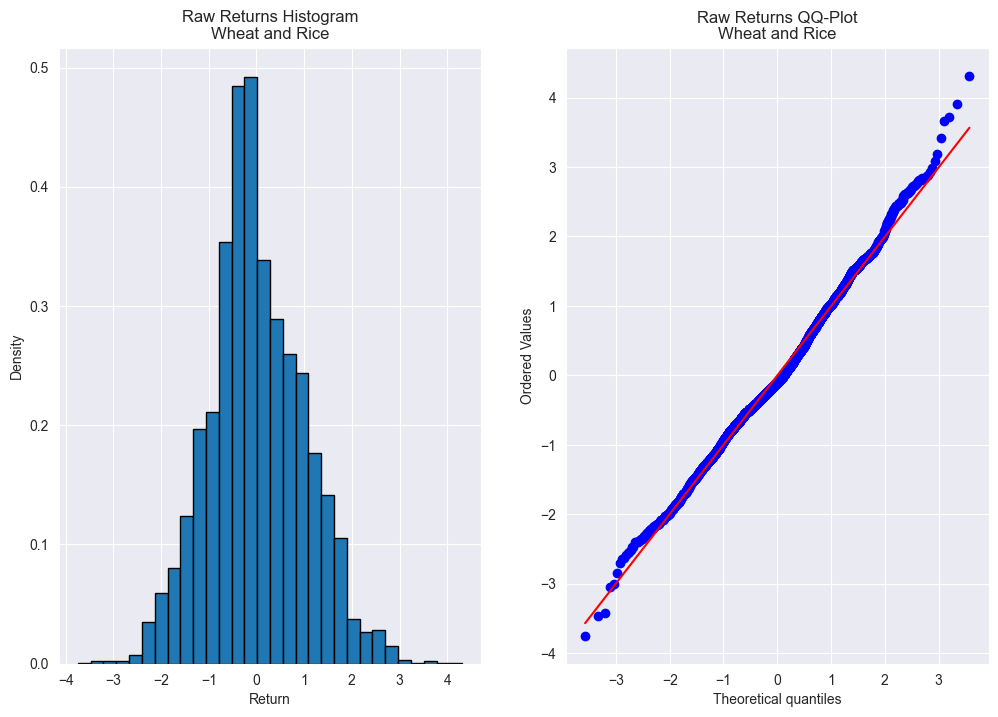

In [7]:
for i, (asset1, asset2) in enumerate(top_5_pairs, 1):
    spread = log_prices_all[asset1] - log_prices_all[asset2]
    spread_z = (spread - spread.mean()) / spread.std()
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    # Top-left: raw histogram
    axes[0].hist(spread_z, bins=30, density=True, edgecolor='k')
    axes[0].set_title(f'Raw Returns Histogram\n{asset1} and {asset2}')
    axes[0].set_xlabel('Return')
    axes[0].set_ylabel('Density')

    # Top-right: raw QQ
    stats.probplot(spread_z, dist="norm", plot=axes[1])
    axes[1].set_title(f'Raw Returns QQ-Plot\n{asset1} and {asset2}')

In [21]:

def select_pairs_from_adf(adf_df, corr_log_returns, adf_pval_threshold=0.05, corr_threshold=0.):
    """
    Seleziona coppie di asset utilizzando i risultati ADF pre-calcolati e filtra per correlazione.

    Args:
        adf_df (pd.DataFrame): risultati ADF con colonne ['Asset 1', 'Asset 2', 'p-value'].
        corr_log_returns (pd.DataFrame): matrice di correlazione dei log-returns.
        adf_pval_threshold (float): soglia p-value per il test di cointegrazione.
        corr_threshold (float): soglia di correlazione in valore assoluto.

    Returns:
        pd.DataFrame: coppie selezionate con p-value e correlazione.
    """
    # 1) Filtra ADF per p-value
    df_sig = adf_df[adf_df['p-value'] < adf_pval_threshold].copy()

    # 2) Aggiunge la correlazione per ciascuna coppia tramite lookup nella matrice
    df_sig['corr'] = df_sig.apply(
        lambda row: corr_log_returns.loc[row['Asset 1'], row['Asset 2']], axis=1
    )

    # 3) Filtra per soglia di correlazione assoluta
    df_filtered = df_sig[abs(df_sig['corr']) > corr_threshold]

    # 4) Ordina per p-value crescente (opzionale)
    df_filtered = df_filtered.sort_values('p-value').reset_index(drop=True)

    return df_filtered

# Esempio:
df_pairs = select_pairs_from_adf(adf_df, corr_log_returns)
print(df_pairs)


  Asset 1 Asset 2  ADF Statistic   p-value      corr
0     Oil   Wheat      -4.469210  0.000223  0.125946
1     Oil    Rice      -4.354948  0.000356  0.065990
2   Wheat    Corn      -4.340674  0.000377  0.561497
3     Oil    Corn      -4.101073  0.000965  0.152561
4   Wheat    Rice      -3.831137  0.002604  0.171196
5    Rice  Copper      -3.673134  0.004507  0.092404
6   Wheat  Copper      -3.635581  0.005116  0.122977
7    Corn  Copper      -3.055007  0.030067  0.140557
8     Oil  Copper      -2.966170  0.038177  0.318497
9   US_2y   Wheat      -2.869386  0.049026 -0.000465
